In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

In [2]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense, concatenate
from sklearn.model_selection import train_test_split
from keras.models import load_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.layers import Concatenate

# 데이터로드

In [6]:
df1 = pd.read_csv('21-01-01~22-12-31강진면.csv')

In [7]:
df2 = pd.read_csv('21-01-01~22-12-31신덕.csv')

In [8]:
df3 = pd.read_csv('21-01-01~22-12-31곡성.csv')

In [9]:
w_df = pd.read_csv('가탄교수위.csv')

In [10]:
print(df1.shape)
print(df2.shape)
print(df3.shape)
print(w_df.shape)

(17520, 10)
(17520, 10)
(17520, 10)
(17523, 2)


In [11]:
w_df = w_df.loc[38:]

In [12]:
w_df

,일시,수위
38,2021-01-02 15:00,0.6
39,2021-01-02 16:00,0.6
40,2021-01-02 17:00,0.6
41,2021-01-02 18:00,0.6
42,2021-01-02 19:00,0.6
...,...,...
17518,2022-12-31 23:00,0.6
17519,2022-12-31 24:00,0.6
17520,2023-01-01 01:00,0.6
17521,2023-01-01 02:00,0.6


/usr/local/lib/python3.10/dist-packages/google/colab/_quickchart_lib.py:137: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/google/colab/_quickchart_lib.py:137: UserWarning: Glyph 50948 (\N{HANGUL SYLLABLE WI}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/google/colab/_quickchart_lib.py:26: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  plt.savefig(
/usr/local/lib/python3.10/dist-packages/google/colab/_quickchart_lib.py:26: UserWarning: Glyph 50948 (\N{HANGUL SYLLABLE WI}) missing from current font.
  plt.savefig(
/usr/local/lib/python3.10/dist-packages/google/colab/_quickchart_lib.py:75: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/google/colab/_quickchart_lib.py:75: UserWarning: Glyph 50948 (\N{HANGUL SYLLABLE WI}) missing from c

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(w_df, *['수위'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(w_df, *['수위'], **{})
chart

# 데이터 전처리

In [13]:
features = ['기온(°C)', '풍향(deg)', '풍속(m/s)', '강수량(mm)', '습도(%)']

In [14]:
test_df1 = df1[features].values
test_df2 = df2[features].values
test_df3 = df3[features].values

In [15]:
test_wdf = w_df[["수위"]].values

In [16]:
print(test_df1.shape)
print(test_df2.shape)
print(test_df3.shape)
print(test_wdf.shape)

(17520, 5)
(17520, 5)
(17520, 5)
(17485, 1)


## 정규화

In [17]:
# 정규화
scaler = MinMaxScaler()

# 상류 하천 데이터 정규화
test_df1_z = scaler.fit_transform(test_df1)
test_df2_z = scaler.fit_transform(test_df2)
test_df3_z = scaler.fit_transform(test_df3)
test_wdf_z = scaler.fit_transform(test_wdf)

In [18]:
test_df1_z

array([[0.26987061, 0.69288703, 0.16666667, 0.        , 0.76744186],
       [0.23844732, 0.76596932, 0.10784314, 0.        , 0.87209302],
       [0.24214418, 0.83542538, 0.1372549 , 0.        , 0.86046512],
       ...,
       [0.30314233, 0.        , 0.00980392, 0.        , 0.94186047],
       [0.29759704, 0.        , 0.00980392, 0.        , 0.94186047],
       [0.2754159 , 0.19414226, 0.06862745, 0.        , 0.97674419]])

In [19]:
test_wdf_z

array([[0.05668016],
       [0.05668016],
       [0.05668016],
       ...,
       [0.05668016],
       [0.05668016],
       [0.05668016]])

In [20]:
print(test_df1_z.shape)
print(test_df2_z.shape)
print(test_df3_z.shape)
print(test_wdf_z.shape)

(17520, 5)
(17520, 5)
(17520, 5)
(17485, 1)


## 차원변환

- 강진면

In [21]:
time_steps = 36

new_data = []

for i in range(len(test_df1_z) - time_steps + 1):
    batch = test_df1_z[i:i+time_steps]
    new_data.append(batch)

test_df1_re = np.array(new_data)

In [ ]:
test_df1_re

In [23]:
test_df1_re.shape

(17485, 36, 5)

- 신덕

In [24]:
new_data = []

for i in range(len(test_df2_z) - time_steps + 1):
    batch = test_df2_z[i:i+time_steps]
    new_data.append(batch)

test_df2_re = np.array(new_data)

In [25]:
test_df2_re.shape

(17485, 36, 5)

- 곡성

In [26]:
new_data = []

for i in range(len(test_df3_z) - time_steps + 1):
    batch = test_df3_z[i:i+time_steps]
    new_data.append(batch)

test_df3_re = np.array(new_data)

In [27]:
test_df3_re.shape

(17485, 36, 5)

In [28]:
print("NumPy array dtype:", test_df2_re.dtype)

NumPy array dtype: float64


- 수위

In [29]:
test_wdf_z.shape  # 위에서 변경함

(17485, 1)

# 모델

- CNN_Lstm

In [30]:
num_top = 3  # 상류 하천의 수
time_steps = 36
# 모델의 입력 레이어 정의
input_layers = []
input_shape = (time_steps, 5)
for i in range(num_top):
    input_layer = Input(shape=input_shape, name=f'aws_{i+1}')
    input_layers.append(input_layer)

# CNN 레이어 정의
cnn_layers = []
for i in range(num_top):
    cnn_layer = Conv1D(filters=64, kernel_size=3, activation='relu')(input_layers[i])
    cnn_layer = MaxPooling1D(pool_size=2)(cnn_layer)
    cnn_layer = Flatten()(cnn_layer)
    cnn_layers.append(cnn_layer)

concatenated_outputs = Concatenate()(cnn_layers)
lstm_input = tf.keras.layers.Reshape((num_top, -1))(concatenated_outputs)  # LSTM에 입력하기 위해 차원 재구성


lstm_layer = LSTM(32, activation='relu')(lstm_input)

output_layer = Dense(1, activation='linear', name='water')(lstm_layer)

In [31]:
# 모델 컴파일
model = Model(inputs=input_layers, outputs=output_layer)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 aws_1 (InputLayer)          [(None, 36, 5)]              0         []                            
                                                                                                  
 aws_2 (InputLayer)          [(None, 36, 5)]              0         []                            
                                                                                                  
 aws_3 (InputLayer)          [(None, 36, 5)]              0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 34, 64)               1024      ['aws_1[0][0]']               
                                                                                              

# 학습

In [32]:
model.fit([test_df1_re, test_df2_re, test_df3_re], test_wdf_z, epochs=100, batch_size=32)

Epoch 1/100
547/547 [==============================] - 10s 14ms/step - loss: 0.0032 - mae: 0.0366
Epoch 2/100
547/547 [==============================] - 7s 12ms/step - loss: 0.0021 - mae: 0.0318
Epoch 3/100
547/547 [==============================] - 7s 14ms/step - loss: 0.0019 - mae: 0.0303
Epoch 4/100
547/547 [==============================] - 6s 11ms/step - loss: 0.0016 - mae: 0.0290
Epoch 5/100
547/547 [==============================] - 7s 14ms/step - loss: 0.0016 - mae: 0.0286
Epoch 6/100
547/547 [==============================] - 6s 11ms/step - loss: 0.0014 - mae: 0.0269
Epoch 7/100
547/547 [==============================] - 8s 14ms/step - loss: 0.0012 - mae: 0.0262
Epoch 8/100
547/547 [==============================] - 6s 11ms/step - loss: 0.0012 - mae: 0.0257
Epoch 9/100
547/547 [==============================] - 8s 14ms/step - loss: 0.0011 - mae: 0.0245
Epoch 10/100
547/547 [==============================] - 7s 13ms/step - loss: 9.9683e-04 - mae: 0.0237
Epoch 11/100
547/547 [==

# 결과

In [33]:
predictions = model.predict([test_df1_re, test_df2_re, test_df3_re])

547/547 [==============================] - 2s 4ms/step


In [34]:
predictions_scale = scaler.inverse_transform(predictions)

In [35]:
predictions_scale.shape

(17485, 1)

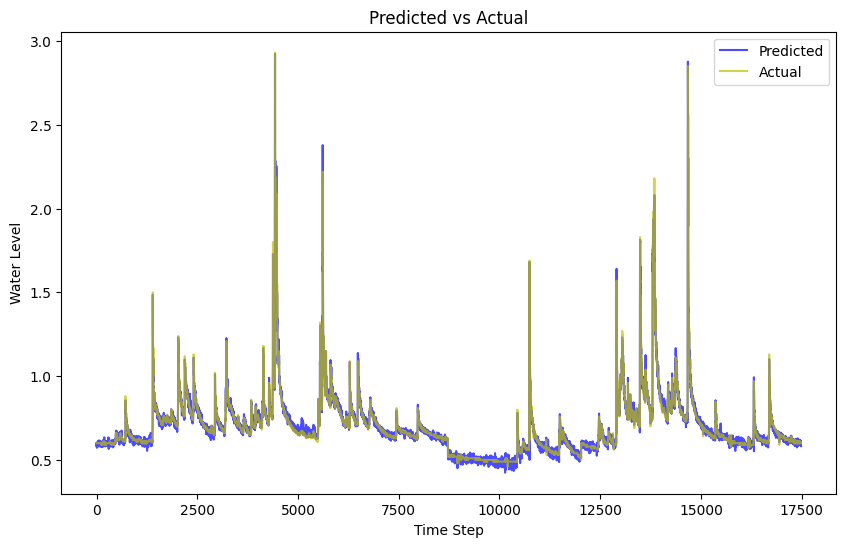

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.plot(predictions_scale, label='Predicted', color = 'b', alpha=0.7)
plt.plot(test_wdf, label='Actual', color = 'y', alpha=0.7)

plt.xlabel('Time Step')
plt.ylabel('Water Level')
plt.title('Predicted vs Actual')
plt.legend()
plt.show()

In [37]:
predictions_scale[:10]

array([[0.6009036 ],
       [0.58912534],
       [0.5981009 ],
       [0.5998342 ],
       [0.59689546],
       [0.58833826],
       [0.57717234],
       [0.5810191 ],
       [0.5962953 ],
       [0.58392113]], dtype=float32)

- 모델저장

In [38]:
model.save("model_test(36)_cnn.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [39]:
from pickle import dump

dump(scaler, open('./36_cnn_scaler.pkl', 'wb'))

# 모델 테스트

- 걍다시 ㄱ

In [ ]:
t1 = pd.read_csv('11111.csv')

In [ ]:
t2 = pd.read_csv('22222.csv')

In [ ]:
t3 = pd.read_csv('33333.csv')

In [ ]:
tw = pd.read_csv('test수위48.csv')

In [ ]:
test_w = tw[["수위"]].values

In [40]:
from keras.models import load_model

model_filename = 'model_test(36)_cnn.h5'

loaded_model = load_model(model_filename)

In [41]:
from pickle import load

load_minmax_scaler = load(open('36_cnn_scaler.pkl', 'rb'))

## 데이터 전처리

In [ ]:
features = ['기온(°C)', '풍향(deg)', '풍속(m/s)', '강수량(mm)', '습도(%)']

In [ ]:
test_t1 = t1[features].values
test_t2 = t2[features].values
test_t3 = t3[features].values

### 정규화

In [ ]:
# 정규화
scaler = MinMaxScaler()

# 상류 하천 데이터 정규화
test_df1_z = scaler.fit_transform(test_t1)
test_df2_z = scaler.fit_transform(test_t2)
test_df3_z = scaler.fit_transform(test_t3)

In [ ]:
time_steps = 48

new_data = []

for i in range(len(test_df1_z) - time_steps + 1):
    batch = test_df1_z[i:i+time_steps]
    new_data.append(batch)

test_df1_re = np.array(new_data)

In [ ]:
test_df1_re.shape

(25, 48, 5)

In [ ]:
new_data = []

for i in range(len(test_df2_z) - time_steps + 1):
    batch = test_df2_z[i:i+time_steps]
    new_data.append(batch)

test_df2_re = np.array(new_data)

In [ ]:
new_data = []

for i in range(len(test_df3_z) - time_steps + 1):
    batch = test_df3_z[i:i+time_steps]
    new_data.append(batch)

test_df3_re = np.array(new_data)

### 결과

In [ ]:
predictions = loaded_model.predict([test_df1_re, test_df2_re, test_df3_re])

1/1 [==============================] - 0s 252ms/step


In [ ]:
predictions

In [ ]:
predictions_scaler = load_minmax_scaler.inverse_transform(predictions)

In [ ]:
predictions_scaler

array([[0.47555807],
       [0.5576896 ],
       [0.5862413 ],
       [0.5750251 ],
       [0.5809162 ],
       [0.58277726],
       [0.631615  ],
       [0.63849574],
       [0.697653  ],
       [0.6972739 ],
       [0.6980707 ],
       [0.6972687 ],
       [0.7007477 ],
       [0.7203783 ],
       [0.7078872 ],
       [0.7281587 ],
       [0.7202893 ],
       [0.6933413 ],
       [0.6567633 ],
       [0.5201135 ],
       [0.5412229 ],
       [0.58299375],
       [0.6062502 ],
       [0.5547263 ],
       [0.55971223]], dtype=float32)

In [ ]:
predictions_scaler.shape

(25, 1)

In [ ]:
test_w

array([[0.66],
       [0.66],
       [0.66],
       [0.66],
       [0.66],
       [0.66],
       [0.66],
       [0.66],
       [0.66],
       [0.66],
       [0.66],
       [0.66],
       [0.66],
       [0.66],
       [0.65],
       [0.65],
       [0.65],
       [0.65],
       [0.65],
       [0.65],
       [0.65],
       [0.65],
       [0.65],
       [0.65],
       [0.66]])

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.plot(predictions_scaler, label='Predicted', color = 'b', alpha=0.7)
plt.plot(test_w, label='Actual', color = 'y', alpha=0.7)

plt.xlabel('Time Step')
plt.ylabel('Water Level')
plt.title('Predicted vs Actual')
plt.legend()
plt.show()

## 3시간 테스트
-> 27개의데이터

In [42]:
t1 = pd.read_csv('test36-1.csv')

In [43]:
t2 = pd.read_csv('test36-2.csv')

In [44]:
t3 = pd.read_csv('test36-3.csv')

In [45]:
features = ['기온(°C)', '풍향(deg)', '풍속(m/s)', '강수량(mm)', '습도(%)']

In [46]:
t3

,지점,지점명,일시,기온(°C),풍향(deg),풍속(m/s),강수량(mm),현지기압(hPa),해면기압(hPa),습도(%)
0,768,곡성,2023-08-16 00:00,25.2,0.0,0.0,0.0,993.8,1005.2,92.0
1,768,곡성,2023-08-16 01:00,24.7,0.0,0.1,0.0,993.6,1004.9,94.0
2,768,곡성,2023-08-16 02:00,25.1,0.0,0.0,0.0,993.4,1004.8,93.0
3,768,곡성,2023-08-16 03:00,25.1,215.0,0.5,0.0,993.5,1004.9,91.0
4,768,곡성,2023-08-16 04:00,24.9,0.0,0.4,0.0,993.2,1004.6,93.0
5,768,곡성,2023-08-16 05:00,25.0,0.0,0.0,0.0,993.2,1004.6,92.0
6,768,곡성,2023-08-16 06:00,24.7,0.0,0.0,0.0,993.5,1004.8,93.0
7,768,곡성,2023-08-16 07:00,25.2,0.0,0.0,0.0,994.0,1005.4,90.0
8,768,곡성,2023-08-16 08:00,26.3,0.0,0.3,0.0,994.3,1005.6,85.0
9,768,곡성,2023-08-16 09:00,26.4,185.8,1.8,0.0,994.4,1005.7,86.0


In [47]:
test_t1 = t1[features].values
test_t2 = t2[features].values
test_t3 = t3[features].values

In [48]:
# 정규화
scaler = MinMaxScaler()

# 상류 하천 데이터 정규화
test_df1_z = scaler.fit_transform(test_t1)
test_df2_z = scaler.fit_transform(test_t2)
test_df3_z = scaler.fit_transform(test_t3)

In [49]:
time_steps = 36

new_data = []

for i in range(len(test_df1_z) - time_steps + 1):
    batch = test_df1_z[i:i+time_steps]
    new_data.append(batch)

test_df1_re = np.array(new_data)

In [50]:
new_data = []

for i in range(len(test_df2_z) - time_steps + 1):
    batch = test_df2_z[i:i+time_steps]
    new_data.append(batch)

test_df2_re = np.array(new_data)

In [51]:
new_data = []

for i in range(len(test_df3_z) - time_steps + 1):
    batch = test_df3_z[i:i+time_steps]
    new_data.append(batch)

test_df3_re = np.array(new_data)

In [52]:
test_df3_re.shape

(3, 36, 5)

In [ ]:
test_df3_re

In [55]:
predictions_t3 = loaded_model.predict([test_df1_re, test_df2_re, test_df3_re])

1/1 [==============================] - 0s 249ms/step


In [57]:
predictions_t3

array([[0.02407827],
       [0.05264486],
       [0.06560145]], dtype=float32)

In [56]:
predictions_scaler_3 = load_minmax_scaler.inverse_transform(predictions_t3)

In [58]:
predictions_scaler_3

array([[0.5194734 ],
       [0.5900328 ],
       [0.62203556]], dtype=float32)

In [59]:
tw1 = pd.read_csv('test수위36-1.csv')

In [60]:
test_w = tw1[["수위"]].values

In [61]:
test_w

array([[0.68],
       [0.67],
       [0.67]])

In [62]:
# RMSE
rmse = np.sqrt(((predictions_scaler_3 - test_w) ** 2).mean())

# MAE
mae = np.abs(predictions_scaler_3 - test_w).mean()

print("RMSE:", rmse)
print("MAE:", mae)

RMSE: 0.10718229865566845
MAE: 0.09615274906158451


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.plot(predictions_scaler_3, label='Predicted', color = 'b', alpha=0.7)
plt.plot(test_w, label='Actual', color = 'y', alpha=0.7)

plt.xlabel('Time Step')
plt.ylabel('Water Level')
plt.title('Predicted vs Actual')
plt.legend()
plt.show()

In [ ]:
predictions_scaler_3

array([[1.0374911 ],
       [0.90322655],
       [1.0528685 ]], dtype=float32)

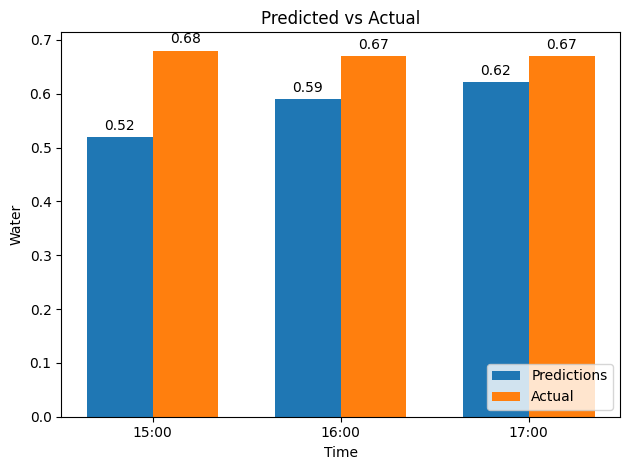

In [65]:
# 데이터 포인트 레이블
data_labels = ['15:00', '16:00', '17:00']

# 그래프 데이터
x = np.arange(len(data_labels))
width = 0.35

# 예측값과 실제값 막대 그래프 생성
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, predictions_scaler_3.flatten(), width, label='Predictions')
rects2 = ax.bar(x + width/2, test_w.flatten(), width, label='Actual')

# 레이블과 범례 설정
ax.set_xlabel('Time')
ax.set_ylabel('Water')
ax.set_title('Predicted vs Actual')
ax.set_xticks(x)
ax.set_xticklabels(data_labels)
ax.legend()

ax.legend(loc='lower right')

# 막대 위에 값 표시
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}', xy=(rect.get_x() + rect.get_width() / 2, height), xytext=(0, 3),
                    textcoords="offset points", ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()